In [2]:
import math
import copy
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.api import SARIMAX
sns.set(style="darkgrid")
%config IPCompleter.greedy = True
%config Completer.use_jedi = False 
sns.mpl.rc('figure',figsize=(20, 6))

In [3]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib inline

In [4]:
%run 8.1-forecasting-methods.ipynb

In [5]:
data_load_second_interval = 5
minute_interval = 1

In [6]:
resample_second_interval = 60*15

In [7]:
resample_minutes = resample_second_interval / 60

In [8]:
hour_observations = int(60/resample_minutes)
half_hour_observations = int(hour_observations/2)
day_observations = int(60/resample_second_interval*60*24)
three_day_observations = int(60/resample_second_interval*60*24*3)
week_observations = int(60/resample_second_interval*60*24*7)

In [9]:
forecast_minutes = 180

In [10]:
forecast_observations = 3 * hour_observations

#### Load data

In [11]:
data = pd.read_csv(f"../../data/corrected_m2/corrected_data_2_{minute_interval}m_{data_load_second_interval}s.csv")
data['ndt'] = pd.to_datetime(data['ndt'])

In [12]:
data = data.groupby('ndt').sum().resample(f'{resample_second_interval}S').sum()

In [13]:
anomaly_free_data = data.copy()

In [14]:
pd.options.mode.chained_assignment = None 

def mean_range(data, start, end):
    past_start = pd.Timestamp(start) - pd.Timedelta(days=1)
    past_end = pd.Timestamp(end) - pd.Timedelta(days=1)
    future_start = pd.Timestamp(start) + pd.Timedelta(days=1)
    future_end = pd.Timestamp(end) + pd.Timedelta(days=1)
    new_vals = data.loc[past_start:past_end]['count'].values + data.loc[future_start:future_end]['count'].values / 2
    data.loc[start:end]['count'] = new_vals
    return data

In [15]:
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 12:30:00','2019-07-22 12:45:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 08:00:00','2019-07-22 08:00:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-22 13:45:00','2019-07-22 13:45:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-24 13:00:00','2019-07-24 13:00:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-07-29 12:15:00','2019-07-29 12:45:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-08-01 13:00:00','2019-08-01 14:15:00')
anomaly_free_data = mean_range(anomaly_free_data, '2019-08-02 14:15:00','2019-08-02 14:45:00')

#### Test and training split

In [16]:
timespan_start = data.index[0]
training_timestamp = pd.date_range(start=timespan_start, end='2019-07-20 08:42:00', freq=f'{resample_second_interval}S')
training_split = len(data.loc[:training_timestamp[-1]])

In [17]:
training_split

3559

In [18]:
data.index[0]

Timestamp('2019-06-13 07:00:00', freq='900S')

In [19]:
data.index[-1]

Timestamp('2019-08-05 05:45:00', freq='900S')

In [20]:
data.index[training_split] 

Timestamp('2019-07-20 08:45:00', freq='900S')

In [21]:
data.index[training_split] - data.index[0]

Timedelta('37 days 01:45:00')

In [14]:
#data.to_csv('../../data/corrected_m2/total_requests_15min.csv')

In [16]:
#data[training_split:].to_csv('../../data/corrected_m2/total_requests_testing_15min.csv')

<AxesSubplot:xlabel='ndt'>

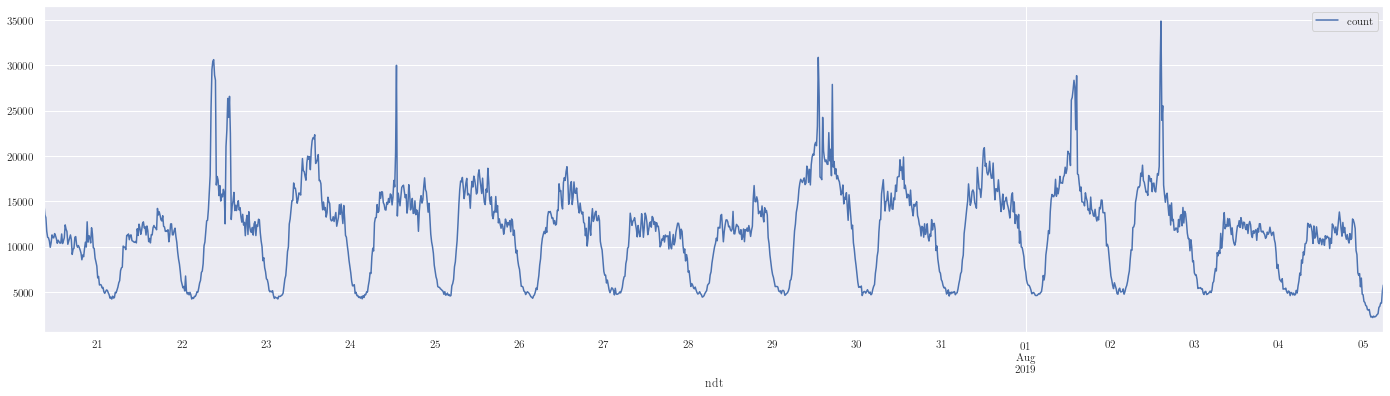

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
anomaly_free_data[training_split:].plot(ax=ax)

#### Load component forecasts

In [23]:
# Sea -> index is last observed value (forecasted at)
arimax_sea_forecasts = pd.read_csv('../../data/forecasts/sea_arimax_forecasts_15.csv', index_col=0, parse_dates=True)
# Peak remainder -> index is last observed value (forecasted at)
arimax_rt_peak_forecasts = pd.read_csv('../../data/forecasts/peaks_rt_arimax_forecasts_15.csv', index_col=0, parse_dates=True)
arimax_speculative_peak_forecasts = pd.read_csv('../../data/forecasts/peaks_speculative_arimax_forecasts_15.csv', index_col=0, parse_dates=True)
# Peak remainder -> index is last observed value (forecasted at)
rfg_forecasts_speculative = pd.read_csv('../../data/forecasts/peaks_largest_rfg_speculative_15.csv', index_col=0, parse_dates=True)
rfg_forecasts = pd.read_csv('../../data/forecasts/peaks_largest_rfg_15.csv', index_col=0, parse_dates=True)

In [24]:
rfg_forecasts.columns = [f'step_{x}' for x in range(1, forecast_observations+1)]

In [25]:
# largest_peaks_through_time -> index is current observed value (forecasted at)

In [26]:
largest_peaks_through_time = pd.read_csv('../../data/peaks/largest_peaks_15.csv', index_col=0, parse_dates=True)
largest_peaks_through_time = pd.DataFrame(largest_peaks_through_time['count'])
largest_peaks_through_time = largest_peaks_through_time[training_split-12:]

In [27]:
largest_peaks_through_time[10:20]

count
2019-07-20 08:15:00  1913.0
2019-07-20 08:30:00  2797.0
2019-07-20 08:45:00  3339.0
2019-07-20 09:00:00  2823.0
2019-07-20 09:15:00  3147.0
2019-07-20 09:30:00  2289.0
2019-07-20 09:45:00  1971.0
2019-07-20 10:00:00  1917.0
2019-07-20 10:15:00  1848.0
2019-07-20 10:30:00  1620.0

In [28]:
# index is shifted back, forecast at 7:00 covers 7:00:01->
#                        observed is 7:00

In [29]:
oracle_tracked_forecast = largest_peaks_through_time.copy()
# Shift index to be a "forecast"
oracle_tracked_forecast.index = oracle_tracked_forecast.index.shift(-1, freq=f'{resample_second_interval}S')

In [30]:
oracle_tracked_forecast[:20]

count
2019-07-20 05:30:00   512.0
2019-07-20 05:45:00   496.0
2019-07-20 06:00:00   649.0
2019-07-20 06:15:00   890.0
2019-07-20 06:30:00   761.0
2019-07-20 06:45:00  1149.0
2019-07-20 07:00:00  1139.0
2019-07-20 07:15:00  1072.0
2019-07-20 07:30:00  1149.0
2019-07-20 07:45:00  1387.0
2019-07-20 08:00:00  1913.0
2019-07-20 08:15:00  2797.0
2019-07-20 08:30:00  3339.0
2019-07-20 08:45:00  2823.0
2019-07-20 09:00:00  3147.0
2019-07-20 09:15:00  2289.0
2019-07-20 09:30:00  1971.0
2019-07-20 09:45:00  1917.0
2019-07-20 10:00:00  1848.0
2019-07-20 10:15:00  1620.0

In [31]:
oracle_tracked_forecast['step_1'] = oracle_tracked_forecast['count'].shift()
for i in range(2, 13):
    oracle_tracked_forecast[f"step_{i}"] = oracle_tracked_forecast[f"step_{i-1}"].shift(-1)
oracle_tracked_forecast = oracle_tracked_forecast.drop(columns='count')[12:]

In [32]:
oracle_tracked_forecast.index = oracle_tracked_forecast.index.shift(-1, freq=f'{resample_second_interval}S')
oracle_tracked_forecast = oracle_tracked_forecast[2:-(forecast_observations-2)]

In [33]:
arimax_sea_forecasts = arimax_sea_forecasts[:-forecast_observations]
arimax_rt_peak_forecasts = arimax_rt_peak_forecasts[:-forecast_observations]
arimax_speculative_peak_forecasts = arimax_speculative_peak_forecasts[:-forecast_observations]
rfg_forecasts_speculative = rfg_forecasts_speculative[:-forecast_observations]
rfg_forecasts = rfg_forecasts[:-forecast_observations]

# HTS

In [34]:
summing_matrix_simplified = np.matrix([
    [1, 1, 1], # Total sum
    [1, 0, 0], # Long-living
    [0, 1, 1], # Short-living
    [1, 0, 0], # Long-Living Series only
    [0, 1, 0], # Short-living Remaining Series only
    [0, 0, 1], # Short-living Tracked Series only
])

In [35]:
def hts_forecast(summing_matrix, data, step):
    input_forecast_matrix = np.matrix([x.values[step] for x in data])
    return summing_matrix * input_forecast_matrix

## Strict real-time method - RF

In [36]:
total_rt = []
long_living_rt = []
short_living_rt = []
long_living_only_rt = []
short_living_remaining_rt = []
short_living_tracked_rt = []

for i in range(0, len(arimax_sea_forecasts)):
    forecasts = hts_forecast(summing_matrix_simplified, [arimax_sea_forecasts, arimax_rt_peak_forecasts, rfg_forecasts], i)
    total_rt.append(forecasts[0].A1)
    long_living_rt.append(forecasts[1].A1)
    short_living_rt.append(forecasts[2].A1)
    long_living_only_rt.append(forecasts[3].A1)
    short_living_remaining_rt.append(forecasts[4].A1)
    short_living_tracked_rt.append(forecasts[5].A1)

total_rt = pd.DataFrame(total_rt, index=arimax_sea_forecasts.index)
long_living_rt = pd.DataFrame(long_living_rt, index=arimax_sea_forecasts.index)
short_living_rt = pd.DataFrame(short_living_rt, index=arimax_sea_forecasts.index)
long_living_only_rt = pd.DataFrame(long_living_only_rt, index=arimax_sea_forecasts.index)
short_living_remaining_rt = pd.DataFrame(short_living_remaining_rt, index=arimax_sea_forecasts.index)
short_living_tracked_rt = pd.DataFrame(short_living_tracked_rt, index=arimax_sea_forecasts.index)

In [37]:
#total_rt.to_csv('../../data/forecasts/total_hts_rt_15.csv')

In [28]:
total_rt = pd.read_csv('../../data/forecasts/total_hts_rt_15.csv', index_col=0, parse_dates=True)

In [52]:
total_errors = []
for row in total_rt.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = data.loc[row_timestamp+pd.Timedelta(minutes=15):row_timestamp+pd.Timedelta(minutes=forecast_minutes)]
    total_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
total_errors = pd.DataFrame(total_errors).fillna(0)

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

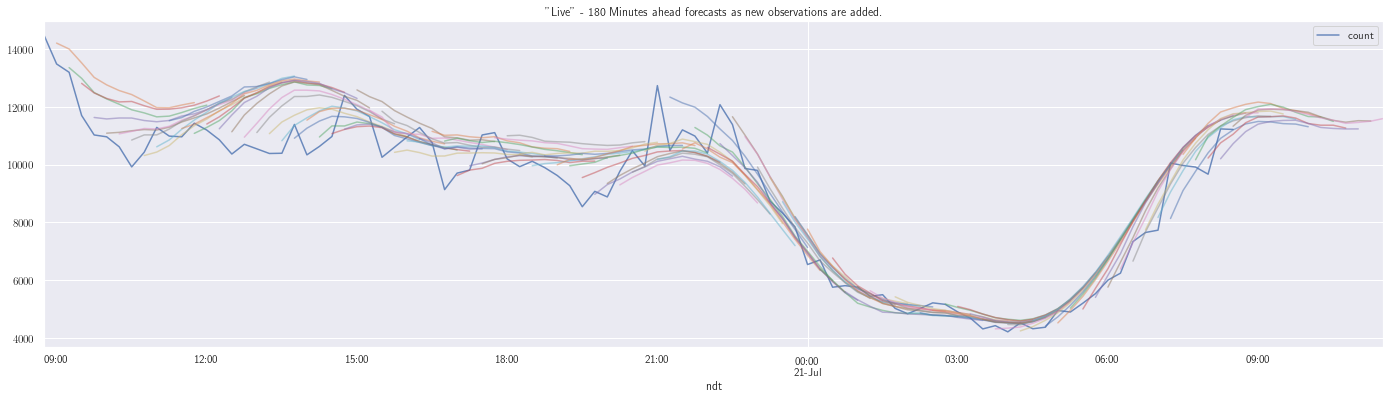

In [53]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in total_rt[:day_observations].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                   start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

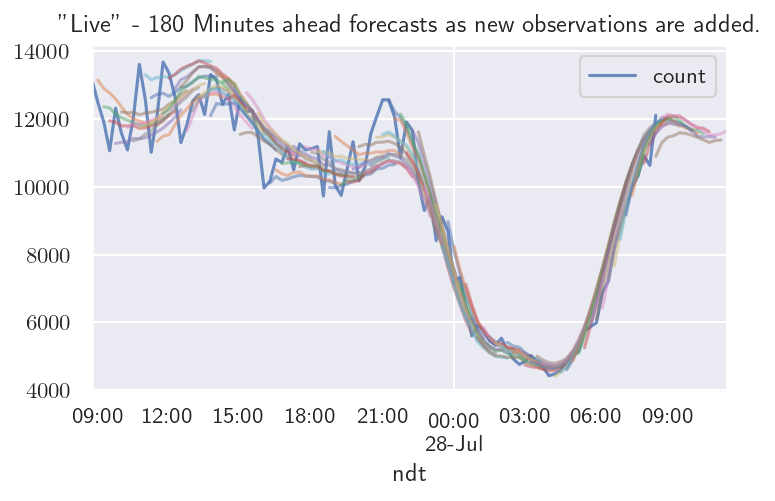

In [54]:
start = day_observations*7
end = day_observations*8

fig, ax = plt.subplots(1, 1, tight_layout=True, dpi=150)
fig.set_size_inches(w=5.10686, h=3.5)
data[training_split+start:training_split+end].plot(ax=ax, alpha=0.8)

for forecast in total_rt[start:end].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)
ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

## Speculative method - RF

In [38]:
total_speculative = []
long_living_speculative = []
short_living_speculative = []
long_living_only_speculative = []
short_living_remaining_speculative = []
short_living_tracked_speculative = []

for i in range(0, len(arimax_sea_forecasts)):
    forecasts = hts_forecast(summing_matrix_simplified, [arimax_sea_forecasts, arimax_speculative_peak_forecasts, rfg_forecasts_speculative], i) # TODO ARIMAX PEAK FORECASTS NOT CALCUALTED!!!
    total_speculative.append(forecasts[0].A1)
    long_living_speculative.append(forecasts[1].A1)
    short_living_speculative.append(forecasts[2].A1)
    long_living_only_speculative.append(forecasts[3].A1)
    short_living_remaining_speculative.append(forecasts[4].A1)
    short_living_tracked_speculative.append(forecasts[5].A1)

total_speculative = pd.DataFrame(total_speculative, index=arimax_sea_forecasts.index)
long_living_speculative = pd.DataFrame(long_living_speculative, index=arimax_sea_forecasts.index)
short_living_speculative = pd.DataFrame(short_living_speculative, index=arimax_sea_forecasts.index)
long_living_only_speculative = pd.DataFrame(long_living_only_speculative, index=arimax_sea_forecasts.index)
short_living_remaining_speculative = pd.DataFrame(short_living_remaining_speculative, index=arimax_sea_forecasts.index)
short_living_tracked_speculative = pd.DataFrame(short_living_tracked_speculative, index=arimax_sea_forecasts.index)

In [39]:
#total_speculative.to_csv('../../data/forecasts/total_hts_speculative_15.csv')

In [57]:
total_errors_speculative = []
for row in total_speculative.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = data.loc[row_timestamp+pd.Timedelta(minutes=15):row_timestamp+pd.Timedelta(minutes=forecast_minutes)]
    total_errors_speculative.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
total_errors_speculative = pd.DataFrame(total_errors_speculative).fillna(0)

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

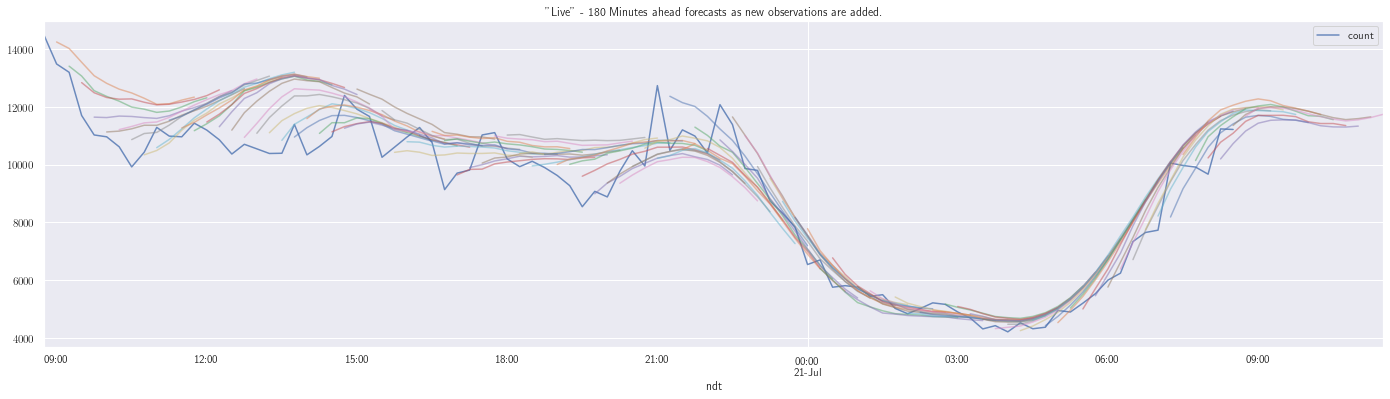

In [58]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in total_speculative[:day_observations].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                   start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

## Oracle method

In [40]:
total_oracle = []
long_living_oracle = []
short_living_oracle = []
long_living_only_oracle = []
short_living_remaining_oracle = []
short_living_tracked_oracle = []

for i in range(0, len(arimax_sea_forecasts)):
    forecasts = hts_forecast(summing_matrix_simplified, [arimax_sea_forecasts, arimax_rt_peak_forecasts, oracle_tracked_forecast], i)
    total_oracle.append(forecasts[0].A1)
    long_living_oracle.append(forecasts[1].A1)
    short_living_oracle.append(forecasts[2].A1)
    long_living_only_oracle.append(forecasts[3].A1)
    short_living_remaining_oracle.append(forecasts[4].A1)
    short_living_tracked_oracle.append(forecasts[5].A1)

total_oracle = pd.DataFrame(total_oracle, index=arimax_sea_forecasts.index)
long_living_oracle = pd.DataFrame(long_living_oracle, index=arimax_sea_forecasts.index)
short_living_oracle = pd.DataFrame(short_living_oracle, index=arimax_sea_forecasts.index)
long_living_only_oracle = pd.DataFrame(long_living_only_oracle, index=arimax_sea_forecasts.index)
short_living_remaining_oracle = pd.DataFrame(short_living_remaining_oracle, index=arimax_sea_forecasts.index)
short_living_tracked_oracle = pd.DataFrame(short_living_tracked_oracle, index=arimax_sea_forecasts.index)

In [41]:
#total_oracle.to_csv('../../data/forecasts/total_hts_oracle_15.csv')

In [59]:
total_oracle = pd.read_csv('../../data/forecasts/total_hts_oracle_15.csv', index_col=0, parse_dates=True)

In [520]:
errors_oracle = []
for row in total_oracle.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = data.loc[row_timestamp+pd.Timedelta(minutes=1):row_timestamp+pd.Timedelta(minutes=30)]
    #break
    errors_oracle.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
errors_oracle = pd.DataFrame(errors_oracle).fillna(0)

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

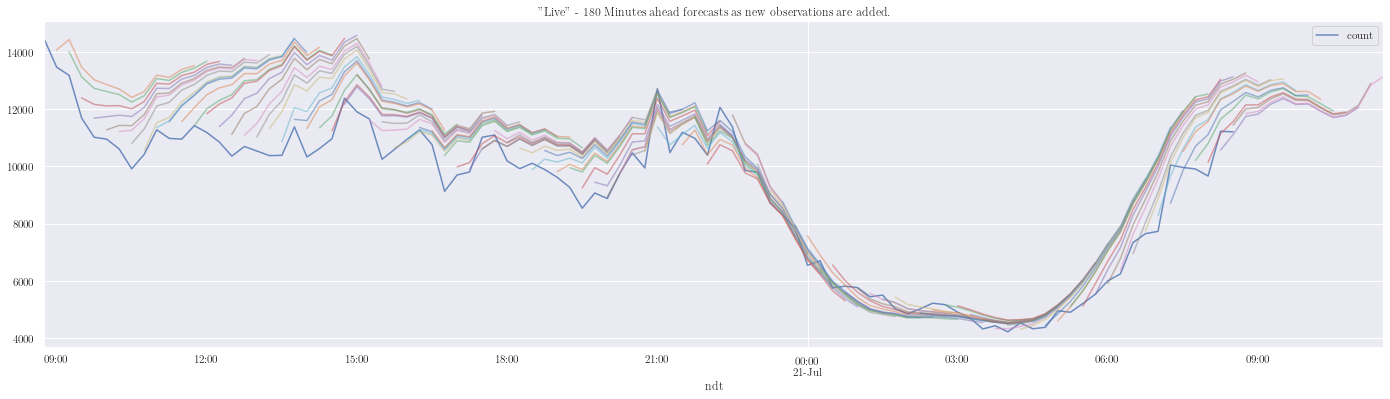

In [521]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in total_oracle[:day_observations].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                   start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

## Naive Method

In [535]:
naive_mod = naive_method(data[:training_split])

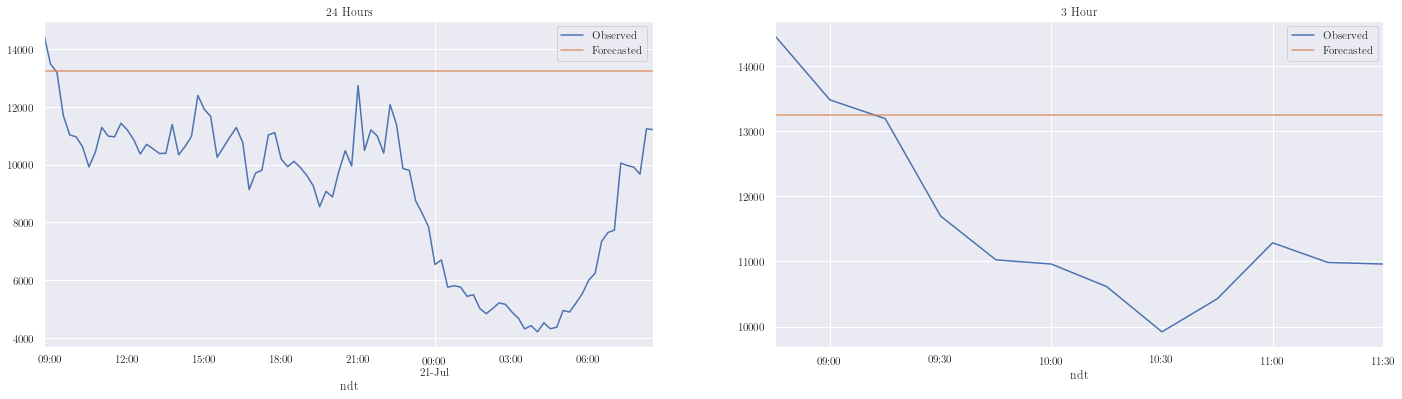

In [187]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(data[training_split:training_split+day_observations], pd.Series(naive_mod.forecast(day_observations)), ax[0])
showcase_zoom(data[training_split:training_split+forecast_observations], pd.Series(naive_mod.forecast(forecast_observations)), ax[1])

In [192]:
naive_mod_forecasts = forecast_n_steps(data, naive_mod, training_split, forecast_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 12 Minutes ahead forecasts as new observations are added.')

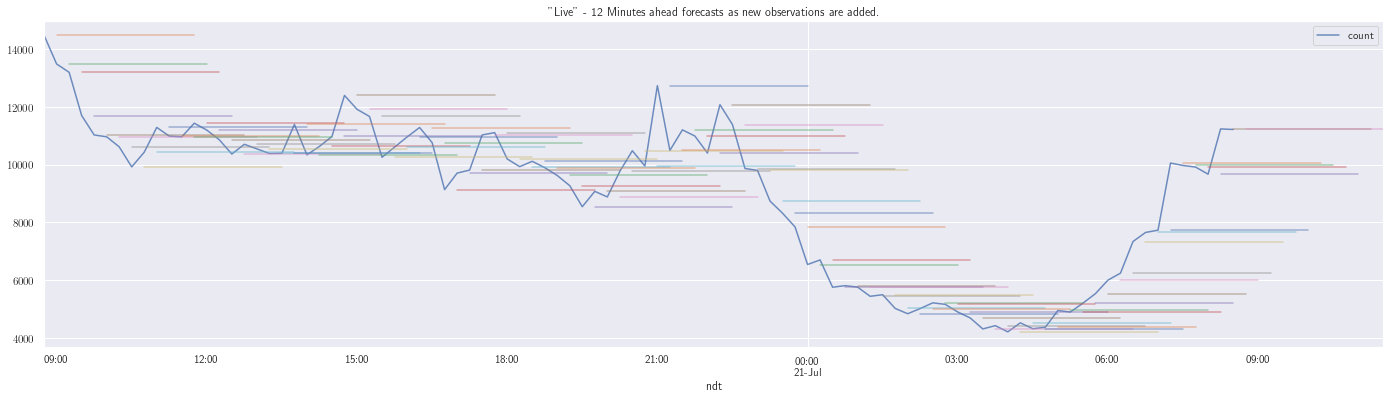

In [236]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in naive_mod_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title(f"\"Live\" - {forecast_observations} Minutes ahead forecasts as new observations are added.")

In [536]:
_, naive_errors = error_n_steps(data, naive_mod, training_split, forecast_observations)

## Average method

In [537]:
average_method_mod = average_method(data[:training_split], forecast_observations)

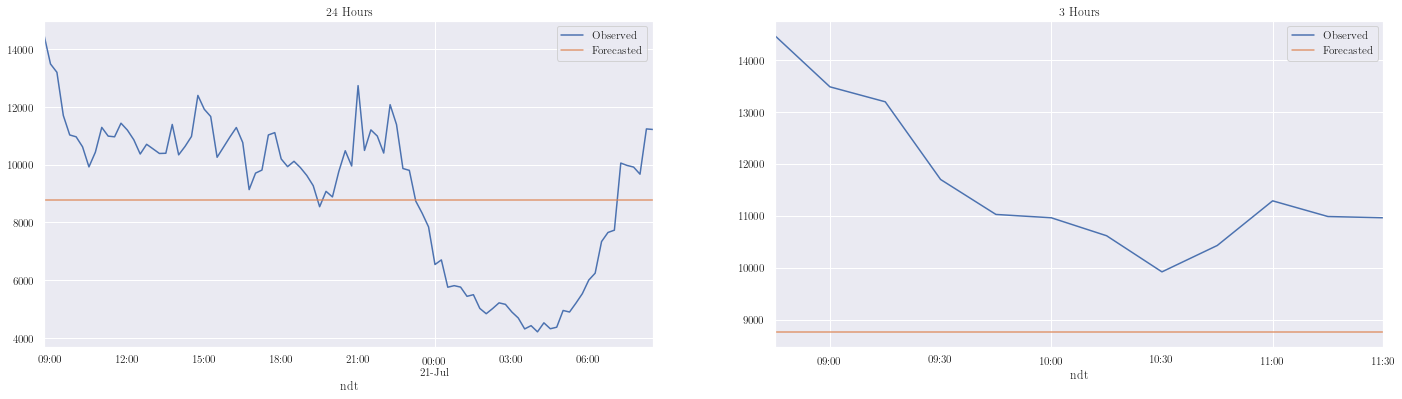

In [127]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hours")
showcase_zoom(data[training_split:training_split+day_observations], pd.Series(average_method_mod.forecast(day_observations)), ax[0])
showcase_zoom(data[training_split:training_split+forecast_observations], pd.Series(average_method_mod.forecast(forecast_observations)), ax[1])

In [196]:
average_method_forecasts = forecast_n_steps(data, average_method_mod, training_split, forecast_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

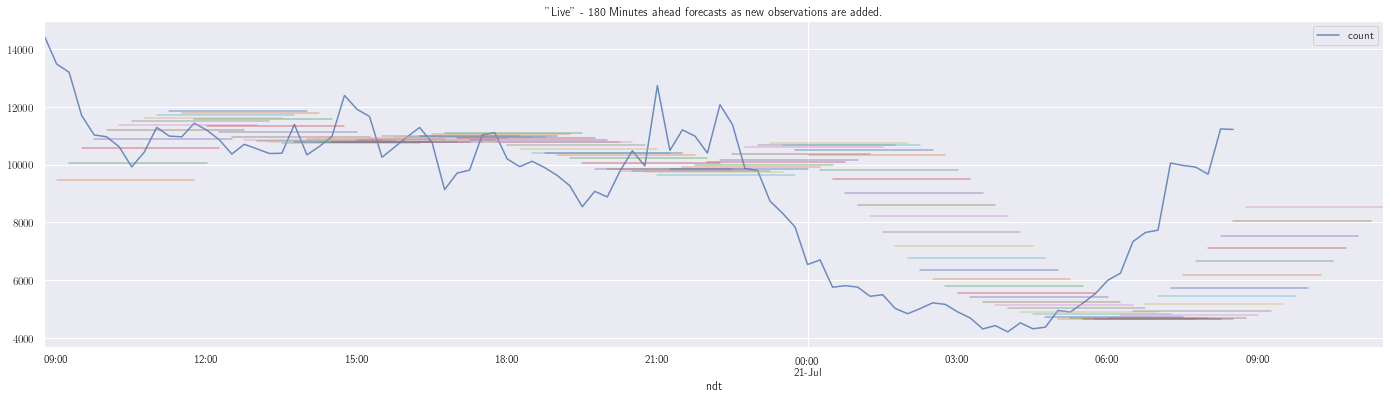

In [235]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in average_method_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

In [538]:
_, average_errors = error_n_steps(data, average_method_mod, training_split, forecast_observations)

## Seasonal Naive Method (24-hour)

In [539]:
seasonal_naive_mod = seasonal_naive_method(data[:training_split], day_observations)

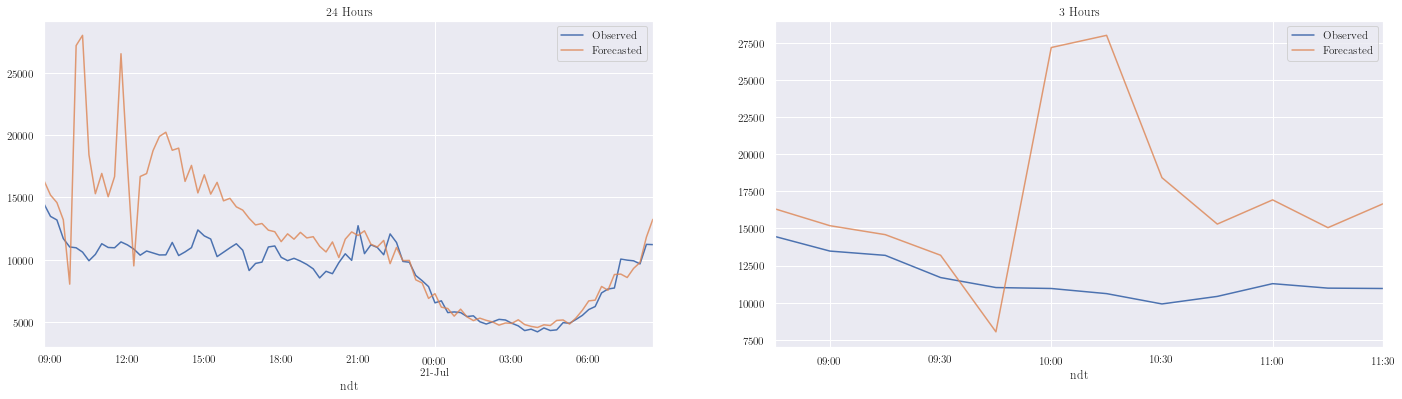

In [136]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hours")
showcase_zoom(data[training_split:training_split+day_observations], pd.Series(seasonal_naive_mod.forecast(day_observations)), ax[0])
showcase_zoom(data[training_split:training_split+forecast_observations], pd.Series(seasonal_naive_mod.forecast(forecast_observations)), ax[1])

In [203]:
seasonal_naive_forecasts = forecast_n_steps(data, seasonal_naive_mod, training_split, forecast_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

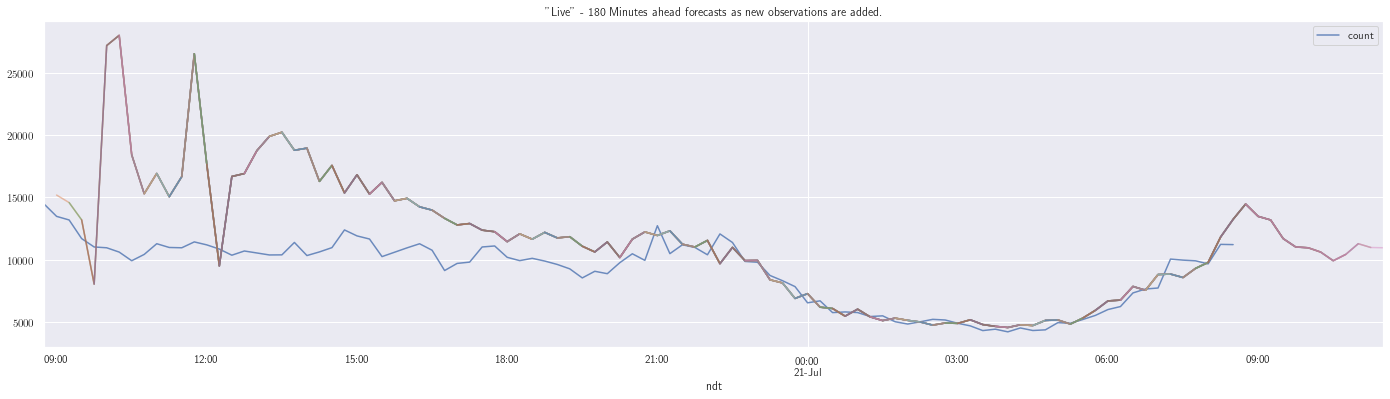

In [234]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in seasonal_naive_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

In [540]:
_, seasonal_naive_errors = error_n_steps(data, seasonal_naive_mod, training_split, forecast_observations)

## AR(1)

In [ ]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/autoregressions.html

In [541]:
ar_1_mod = SARIMAX(data[:training_split], order=(1,0,0), trend='c')
ar_1_res = ar_1_mod.fit()

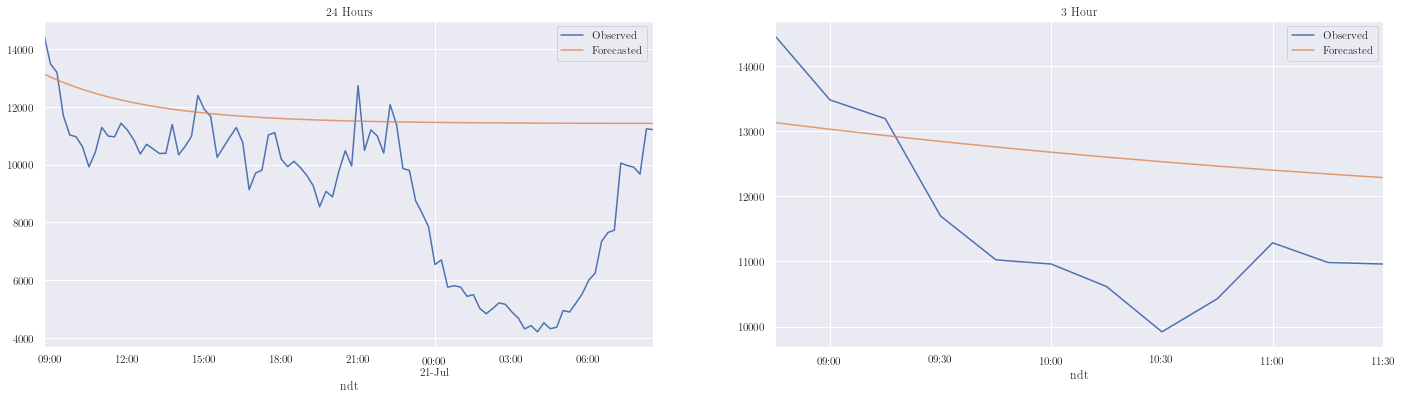

In [145]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(data[training_split:training_split+day_observations], pd.Series(ar_1_res.forecast(day_observations)), ax[0])
showcase_zoom(data[training_split:training_split+forecast_observations], pd.Series(ar_1_res.forecast(forecast_observations)), ax[1])

In [210]:
ar_1_forecasts = forecast_n_steps(data, ar_1_res, training_split, forecast_observations, end=training_split+day_observations)

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

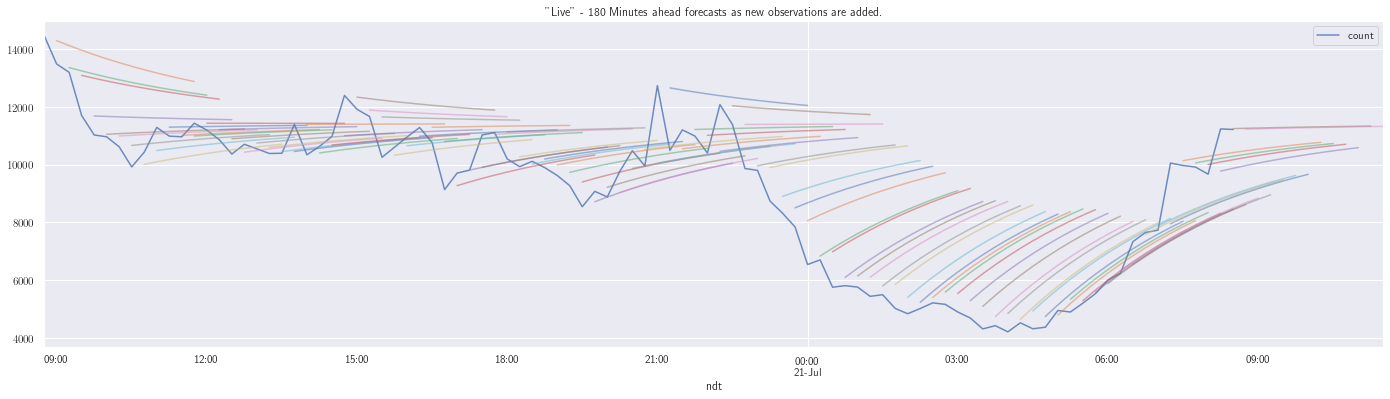

In [233]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in ar_1_forecasts[1].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)

ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

In [542]:
_, ar1_errors = error_n_steps(data, ar_1_res, training_split, forecast_observations)

# TBATS

In [543]:
from tbats import TBATS

In [544]:
tbats_mod = TBATS(seasonal_periods=[day_observations], use_box_cox=False)

In [545]:
tbats_res = tbats_mod.fit(data[:training_split])

In [546]:
tbats_res.summary()

'Use Box-Cox: False\nUse trend: True\nUse damped trend: True\nSeasonal periods: [96.]\nSeasonal harmonics [5]\nARMA errors (p, q): (2, 3)\nSmoothing (Alpha): 1.141278\nTrend (Beta): -0.263537\nDamping Parameter (Phi): 0.800000\nSeasonal Parameters (Gamma): [-5.16710981e-07  1.76956831e-06]\nAR coefficients [1.76956831e-06 8.79275531e-03]\nMA coefficients [ 0.017828   -0.09061481  0.07040387]\nSeed vector [11452.66437676  -195.43906803 -1458.18913376   723.68287477\n   806.43421682   109.99239361   267.4657829   4603.88818033\n  1859.81557031  -282.45775914   602.3443823    439.50282771\n     0.             0.             0.             0.\n     0.        ]\n\nAIC 81642.391744'

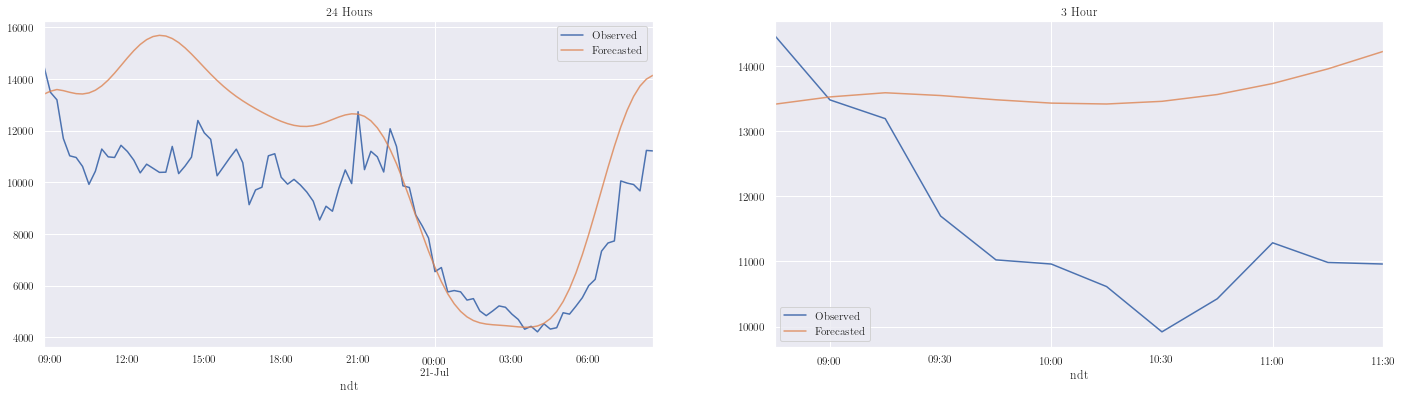

In [154]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(data[training_split:training_split+day_observations], pd.Series(tbats_res.forecast(day_observations)), ax[0])
showcase_zoom(data[training_split:training_split+forecast_observations], pd.Series(tbats_res.forecast(forecast_observations)), ax[1])

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

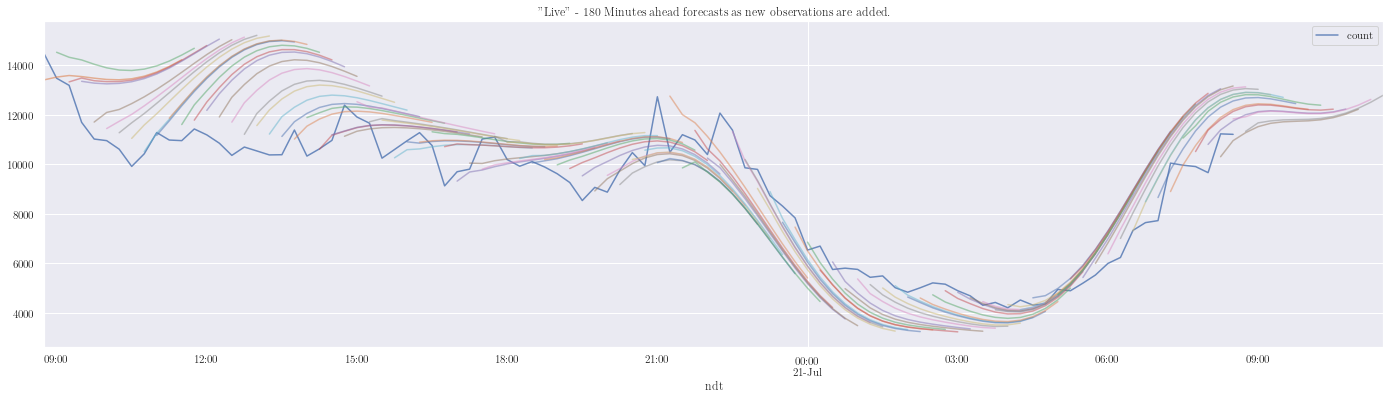

In [155]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

vis_tbats = copy.deepcopy(tbats_res)

pd.Series(vis_tbats.forecast(forecast_observations), index=data.index[training_split:training_split+forecast_observations]).plot(ax=ax, alpha=0.6)
for i in range(1, day_observations+1): # 24 hour ahead
    vis_tbats.fit(data[:training_split+i])
    pd.Series(vis_tbats.forecast(forecast_observations), index=data.index[training_split+i:training_split+i+forecast_observations]).plot(ax=ax, alpha=0.5)
ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

In [547]:
_, tbats_errors = error_n_steps(data, copy.deepcopy(tbats_res), training_split, forecast_observations)

## ARIMA with Fourier Terms

In [69]:
from pmdarima.preprocessing import FourierFeaturizer
import pmdarima as pm

In [70]:
resulting_models = []
for d_k in range(1, 12):
        daily_transformation = FourierFeaturizer(m=day_observations, k=d_k)
        _, exog_d = daily_transformation.fit_transform(data[:training_split])
        print(d_k)
        ft_fit = pm.auto_arima(data[:training_split],
                             start_q = 2,
                             max_q = 20,
                             start_p = 2,
                             max_p = 20,
                             D = None,
                             exogenous=exog_d,
                             max_order = 30,
                             seasonal = False,
                             information_criterion = 'aic',
                             stepwise = True, # n_jobs = 16
                             trace = 2,
                             cov_type=None
                            )
        resulting_models.append(ft_fit)

1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=62950.448, Time=3.46 sec
First viable model found (62950.448)
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=102477.697, Time=0.22 sec
Near non-invertible roots for order (1, 0, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.990)
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=72554.061, Time=2.99 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=62952.575, Time=0.87 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=62975.646, Time=2.99 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=62944.837, Time=5.41 sec
New best model found (62944.837 < 62950.448)
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=62949.756, Time=4.18 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=62946.744, Time=6.24 sec
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close 

In [71]:
smallest_aic = min(resulting_models, key=lambda x: x.aic())

In [72]:
smallest_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3559
Model:               SARIMAX(2, 0, 4)   Log Likelihood              -31289.618
Date:                Sun, 07 Mar 2021   AIC                          62613.236
Time:                        23:40:14   BIC                          62718.249
Sample:                             0   HQIC                         62650.682
                               - 3559                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
FOURIER_S96-0  4539.1193    379.482     11.961      0.000    3795.347    5282.891
FOURIER_C96-0 -1722.3609    517.377     -3.329      0.001   -2736.400    -708.322
FOURIER_S96-1  1967.7644    439.061      4.482      0.000    1107.221    2828.308
FOURIER_C96-1   498.2077    420.934      1.184      0.237    -326.808    1323.223
FOURIER_S96-2   -91.5912    377.954     -0.242      0.809    -832.368     649.186
FOURIER_C96-2   863.4462    373.135      2.314      0.021     132.116    1594.777
FOURIER_S96-3   638.0198    326.949      1.951      0.051      -2.789    1278.829
FOURIER_C96-3   -38.3960    300.768     -0.128      0.898    -627.890     551.098
FOURIER_S96-4   528.6064    204.791      2.581      0.010     127.224     929.989
FOURIER_C96-4   117.2289    204.086      0.574      0.566    -282.773     517.231
ar.L1             1.7386      0.010    180.236      0.000       1.720       1.757
ar.L2            -0.7386      0.010    -76.669      0.000      -0.757      -0.720
ma.L1            -0.7923      0.010    -75.953      0.000      -0.813      -0.772
ma.L2            -0.1871      0.008    -22.395      0.000      -0.203      -0.171
ma.L3             0.1236      0.007     17.719      0.000       0.110       0.137
ma.L4            -0.1171      0.008    -14.991      0.000      -0.132      -0.102
sigma2         2.537e+06      1.927   1.32e+06      0.000    2.54e+06    2.54e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            766391.86
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             2.77
Prob(H) (two-sided):                  0.03   Kurtosis:                        74.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.93e+21. Standard errors may be unstable.
"""

In [73]:
print(smallest_aic, smallest_aic.aic())

 ARIMA(2,0,4)(0,0,0)[0]           62613.23565391965


In [ ]:
# K = 5

### Selected model

In [42]:
fourier_dp = DeterministicProcess(data.index, period=day_observations, fourier=5)
exog_fourier = fourier_dp.in_sample()

In [43]:
exog_fourier = exog_fourier.append(
                fourier_dp.out_of_sample(forecast_observations,
                                       forecast_index=pd.date_range(
                                               start=exog_fourier.index[-1]+pd.Timedelta(minutes=15),
                                               periods=forecast_observations,
                                               freq=f"{resample_second_interval}S")))

In [44]:
arimax_mod = SARIMAX(anomaly_free_data[:training_split], order=(2, 0, 4), exog=exog_fourier[:training_split], trend='c')
arimax_res = arimax_mod.fit()
print(arimax_res.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                 3559
Model:               SARIMAX(2, 0, 4)   Log Likelihood              -31295.355
Date:                Wed, 07 Apr 2021   AIC                          62626.710
Time:                        19:58:21   BIC                          62737.900
Sample:                    06-13-2019   HQIC                         62666.359
                         - 07-20-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1452.8827    465.080      3.124      0.002     541.343    2364.422
sin(1,96)   4642.3344    719.317      6.454      0.000    3232.499    6052.170
cos(1,96)  -1421.4418    710.869     -2.000      0.0

In [164]:
#joblib.dump(arimax_res, open(f'../../models/arimax_peaks_{minute_interval}_{resample_second_interval}', 'wb'))

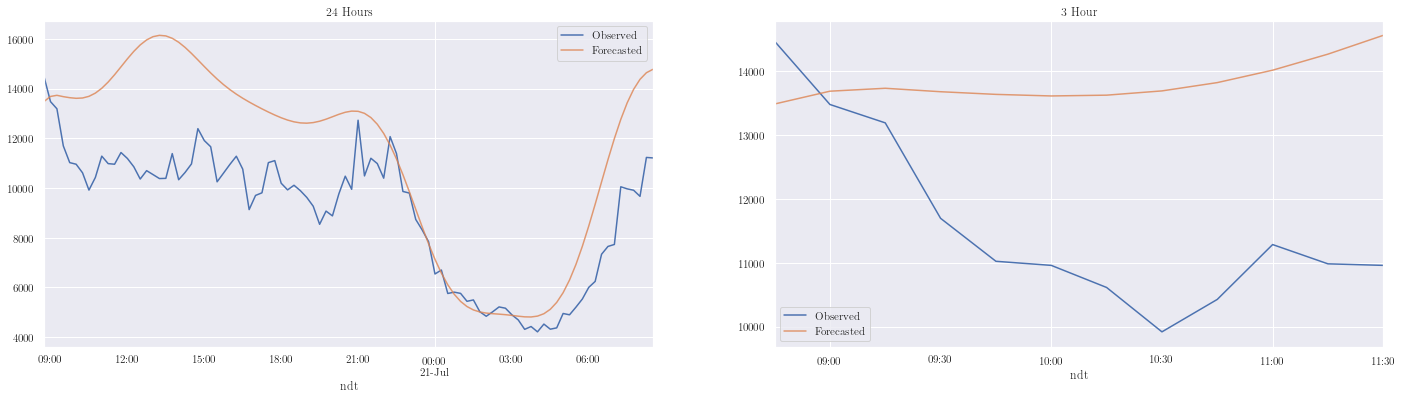

In [165]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(data[training_split:training_split+day_observations],
              pd.Series(arimax_res.forecast(
                    day_observations,
                    exog=exog_fourier[training_split:training_split+day_observations])),
              ax[0])
showcase_zoom(data[training_split:training_split+forecast_observations],
              pd.Series(arimax_res.forecast(
                    forecast_observations,
                    exog=exog_fourier[training_split:training_split+forecast_observations])),
              ax[1])

In [45]:
arimax_timestamps = []
arimax_forecasts = []
for step in range(training_split, len(anomaly_free_data)):
    clear_output(wait=True)
    print("Step: ", step + 1, "-", len(anomaly_free_data), "; %:", (step + 1)/len(anomaly_free_data), end='\r')
    data_extended = data[step:step+1]
    arimax_timestamps.append(data_extended.index[0])
    arimax_res = arimax_res.append(data_extended, exog=exog_fourier[step:step+1])
    forecast_exog = exog_fourier[step:step+forecast_observations]
    arimax_forecasts.append(arimax_res.forecast(min(forecast_observations, len(forecast_exog)), exog=forecast_exog).values)
arimax_forecasts = pd.DataFrame(index=arimax_timestamps, data=arimax_forecasts, columns=[f"step_{x}" for x in range(1, forecast_observations+1)])
del arimax_timestamps

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

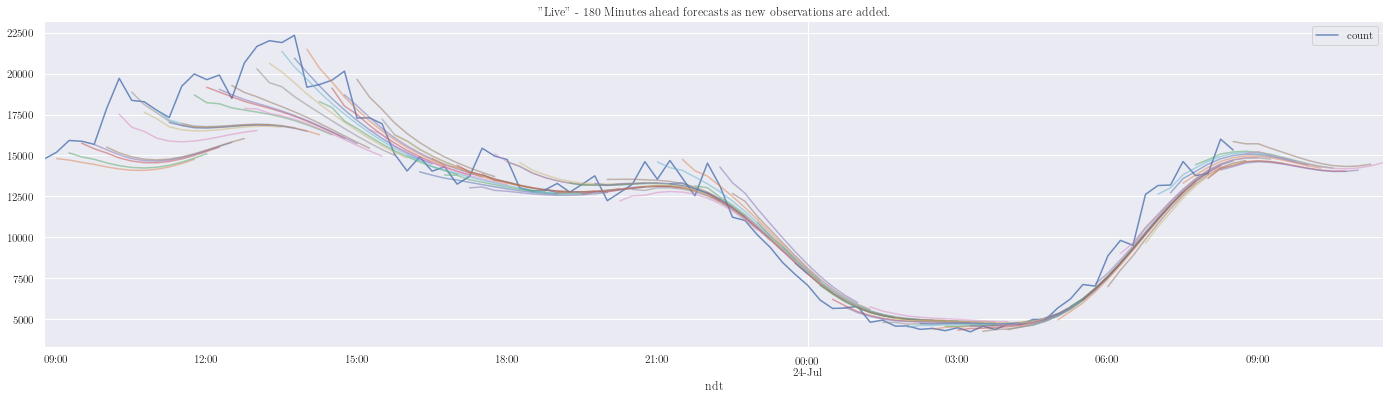

In [68]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split+day_observations*3:training_split+day_observations*4].plot(ax=ax, alpha=0.8)

for forecast in arimax_forecasts[day_observations*3:day_observations*4].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)
ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

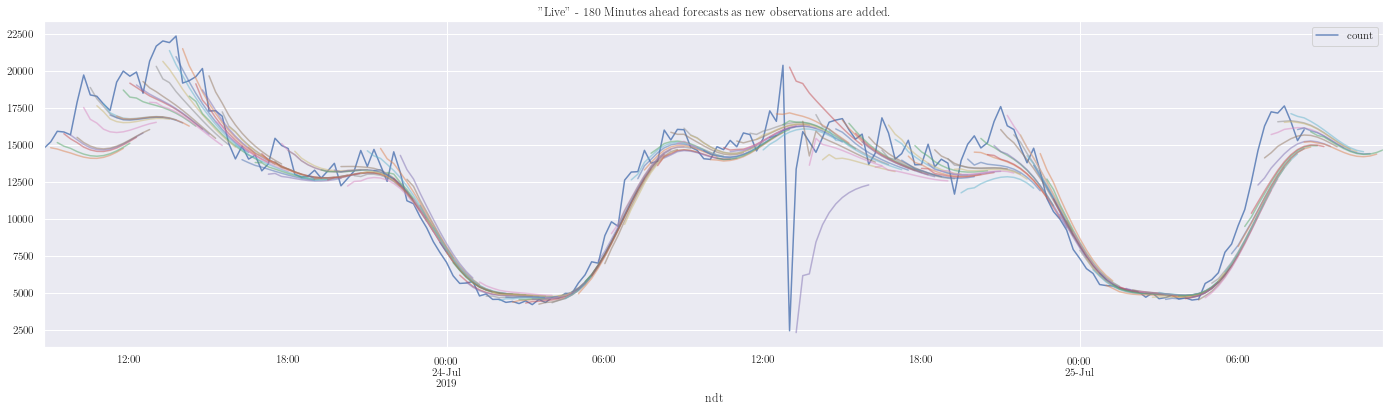

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
data[training_split+day_observations*3:training_split+day_observations*5].plot(ax=ax, alpha=0.8)

for forecast in arimax_forecasts[day_observations*3:day_observations*5].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)
ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

In [46]:
#arimax_forecasts.to_csv('../../data/forecasts/total_arimax_forecasts_15.csv')

In [60]:
arimax_forecasts = pd.read_csv('../../data/forecasts/total_arimax_forecasts_15.csv', index_col=0, parse_dates=True)

In [552]:
arimax_errors = []
for row in arimax_forecasts.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = data.loc[row_timestamp+pd.Timedelta(minutes=15):row_timestamp+pd.Timedelta(minutes=forecast_minutes)]
    #break
    arimax_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
arimax_errors = pd.DataFrame(arimax_errors).fillna(0)

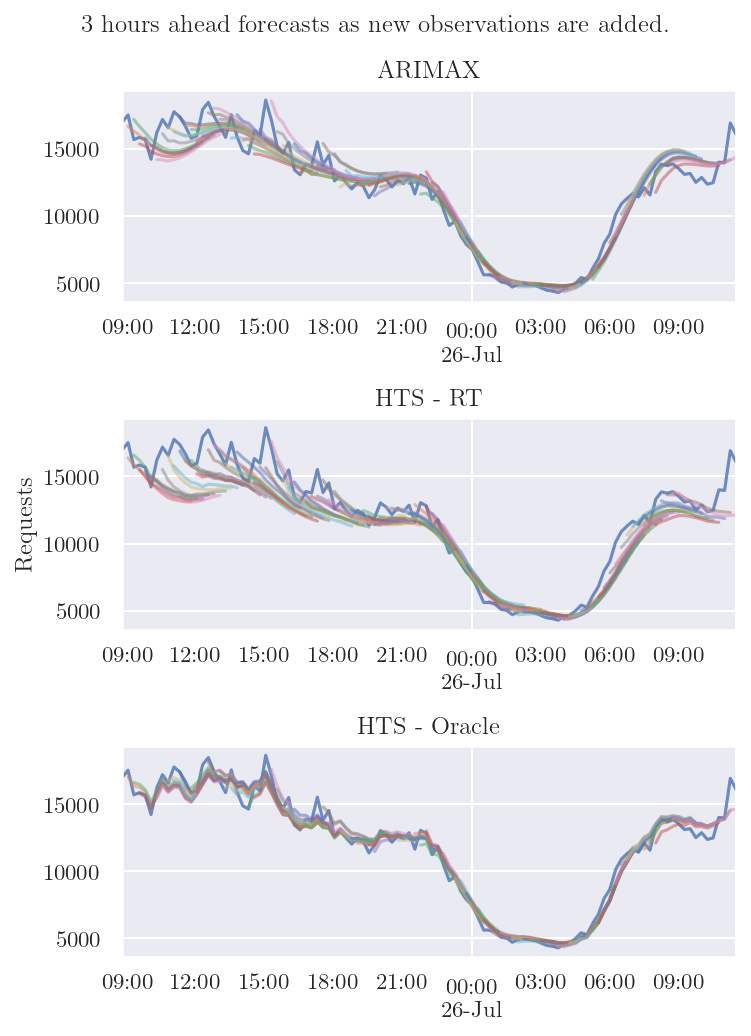

In [77]:
start = day_observations*5
end = day_observations*6

fig, ax = plt.subplots(3, 1, tight_layout=True, dpi=150)
fig.set_size_inches(w=5.10686, h=7)

data[training_split+start:training_split+end+12].plot(ax=ax[0], alpha=0.8)
for forecast in arimax_forecasts[start:end].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax[0], alpha=0.5)
    
data[training_split+start:training_split+end+12].plot(ax=ax[1], alpha=0.8)
for forecast in total_rt[start:end].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax[1], alpha=0.5)
    
    
data[training_split+start:training_split+end+12].plot(ax=ax[2], alpha=0.8)
for forecast in total_oracle[start:end].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax[2], alpha=0.5)
    
fig.suptitle(f"3 hours ahead forecasts as new observations are added.")
ax[0].set_title("ARIMAX")
ax[1].set_title("HTS - RT")
ax[2].set_title("HTS - Oracle")
ax[1].set_ylabel("Requests")
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[2].set_xlabel("")
ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[2].get_legend().remove()
#fig.savefig('../../plots/text-plots/8-15min-arimax-example.pgf')

# Evaluation

## Error sums 

In [553]:
arimax_mse, arimax_rmse = rmse_forecasts(arimax_errors)
naive_mse, naive_rmse = rmse_forecasts(naive_errors)
average_mse, average_rmse = rmse_forecasts(average_errors)
seasonal_naive_mse, seasonal_naive_rmse = rmse_forecasts(seasonal_naive_errors)
ar1_mse, ar1_rmse = rmse_forecasts(ar1_errors)
tbats_mse, tbats_rmse = rmse_forecasts(tbats_errors)
total_rt_mse, total_rt_rmse = rmse_forecasts(total_errors)
total_speculative_mse, total_speculative_rmse = rmse_forecasts(total_errors_speculative)
oracle_mse, oracle_rmse = rmse_forecasts(errors_oracle)

In [557]:
forecast_errors = pd.DataFrame()
forecast_errors['naive_mse'] = naive_mse
forecast_errors['naive_rmse'] = naive_rmse
forecast_errors['average_mse'] = average_mse
forecast_errors['average_rmse'] = average_rmse
forecast_errors['seasonal_naive_mse'] = seasonal_naive_mse
forecast_errors['seasonal_naive_rmse'] = seasonal_naive_rmse
forecast_errors['ar1_mse'] = ar1_mse
forecast_errors['ar1_rmse'] = ar1_rmse
forecast_errors['arimax_mse'] = arimax_mse
forecast_errors['arimax_rmse'] = arimax_rmse
forecast_errors['tbats_mse'] = tbats_mse
forecast_errors['tbats_rmse'] = tbats_rmse
forecast_errors['total_rt_mse'] = total_rt_mse
forecast_errors['total_rt_rmse'] = total_rt_rmse
forecast_errors['total_speculative_mse'] = total_speculative_mse
forecast_errors['total_speculative_rmse'] = total_speculative_rmse
forecast_errors['oracle_mse'] = oracle_mse
forecast_errors['oracle_rmse'] = oracle_rmse

In [65]:
#forecast_errors.to_csv("../../data/forecasts/total_errors_15.csv")

In [62]:
forecast_errors = pd.read_csv("../../data/forecasts/total_errors_15.csv", index_col=0)

In [ ]:
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(24, 18)

arimax_residues = pd.Series(arimax_errors.values.flatten())
tbats_residues = pd.Series(tbats_errors.values.flatten())
ar1_residues = pd.Series(ar1_errors.values.flatten())
naive_residues = pd.Series(naive_errors.values.flatten())
seasonal_naive_residues = pd.Series(seasonal_naive_errors.values.flatten())
average_residues = pd.Series(average_errors.values.flatten())
total_rt_residues = pd.Series(total_errors.values.flatten())
total_speculative_residues = pd.Series(total_errors_speculative.values.flatten())


sns.histplot(arimax_residues, ax=ax[0][0], stat='density', kde=True)
ax[0][0].set_title("ARIMAX with Fourier terms residuals distribution")

sns.histplot(tbats_residues, ax=ax[0][1], stat='density', kde=True)
ax[0][1].set_title("TBATS residuals distribution")

sns.histplot(ar1_residues, ax=ax[1][0], stat='density', kde=True)
ax[1][0].set_title("AR(1) residuals distribution")

sns.histplot(naive_residues, ax=ax[1][1], stat='density', kde=True)
ax[1][1].set_title("Naive residuals distribution")

sns.histplot(seasonal_naive_residues, ax=ax[2][0], stat='density', kde=True)
ax[2][0].set_title("Seasonal naive residuals distribution")

sns.histplot(average_residues, ax=ax[2][1], stat='density', kde=True)
ax[2][1].set_title("Average residuals distribution")

sns.histplot(total_rt_residues, ax=ax[3][0], stat='density', kde=True)
ax[3][0].set_title("Real-time method residuals distribution")

sns.histplot(total_speculative_residues, ax=ax[3][1], stat='density', kde=True)
ax[3][1].set_title("Speculative method residuals distribution")

In [528]:
tbats_rmse.index = data[-len(tbats_mse):].index
arimax_rmse.index = data[-len(arimax_mse):].index
naive_rmse.index = data[-len(naive_rmse):].index
average_rmse.index = data[-len(average_rmse):].index
seasonal_naive_rmse.index = data[-len(seasonal_naive_rmse):].index
ar1_rmse.index = data[-len(ar1_rmse):].index
total_rt_rmse.index = data[-len(total_rt_rmse):].index
total_speculative_rmse.index = data[-len(total_speculative_rmse):].index
oracle_rmse.index = data[-len(oracle_rmse):].index

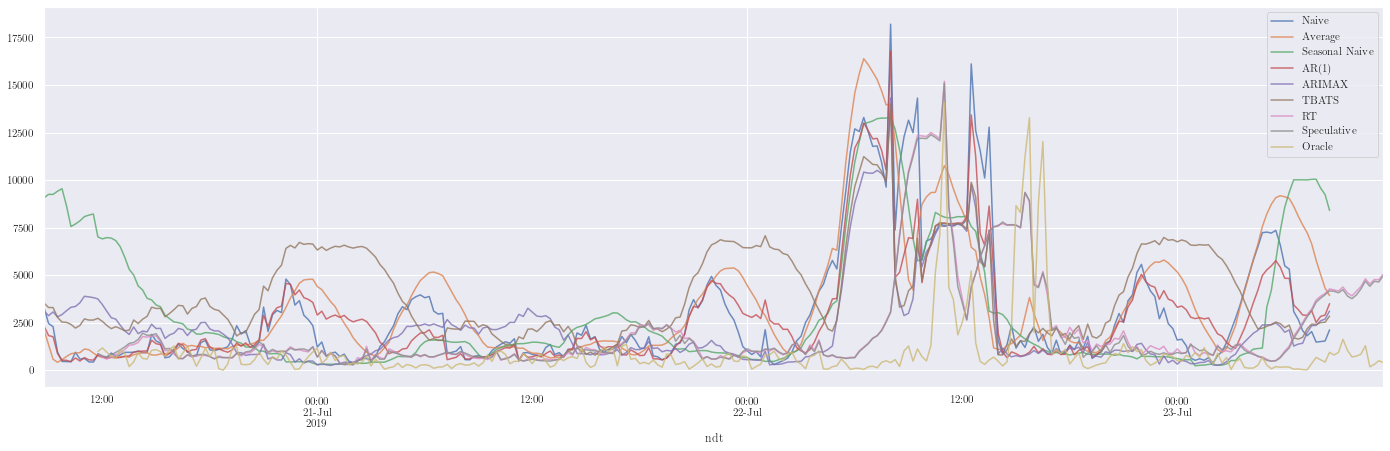

In [529]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 7)

naive_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
average_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
seasonal_naive_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
ar1_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
arimax_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
tbats_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
total_rt_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
total_speculative_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
oracle_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
ax.legend(["Naive", "Average", "Seasonal Naive", "AR(1)", "ARIMAX", "TBATS", "RT", "Speculative", "Oracle"])

In [68]:
results = pd.DataFrame(
            data=np.array([
                forecast_errors['tbats_rmse'].sum(),
                forecast_errors['tbats_mse'].sum(),
                forecast_errors['arimax_rmse'].sum(),
                forecast_errors['arimax_mse'].sum(),
                forecast_errors['naive_rmse'].sum(),
                forecast_errors['naive_mse'].sum(),
                forecast_errors['seasonal_naive_rmse'].sum(),
                forecast_errors['seasonal_naive_mse'].sum(),
                forecast_errors['average_rmse'].sum(),
                forecast_errors['average_mse'].sum(),
                forecast_errors['ar1_rmse'].sum(),
                forecast_errors['ar1_mse'].sum(),
                forecast_errors['total_rt_rmse'].sum(),
                forecast_errors['total_rt_mse'].sum(),
                forecast_errors['total_speculative_rmse'].sum(),
                forecast_errors['total_speculative_mse'].sum(),
                forecast_errors['oracle_rmse'].sum(),
                forecast_errors['oracle_mse'].sum()
            ])
                .reshape(1, -1),
            columns = ['tbats_rmse','tbats_mse',
                       'arimax_rmse','arimax_mse',
                       'naive_rmse', 'naive_mse',
                       'seasonal_naive_rmse', 'seasonal_naive_mse',
                       'average_rmse','average_mse',
                       'ar1_rmse','ar1_mse',
                       'total_rt_rmse','total_rt_mse',
                       'total_speculative_rmse', 'total_speculative_mse',
                       'oracle_rmse', 'oracle_mse'
                      ])

In [69]:
results

tbats_rmse     tbats_mse   arimax_rmse    arimax_mse    naive_rmse  \
0  5.431896e+06  2.702783e+10  2.663366e+06  9.270467e+09  4.116270e+06   

      naive_mse  seasonal_naive_rmse  seasonal_naive_mse  average_rmse  \
0  2.049993e+10         3.916308e+06        2.088976e+10  5.285983e+06   

    average_mse      ar1_rmse       ar1_mse  total_rt_rmse  total_rt_mse  \
0  2.805383e+10  3.995719e+06  1.692639e+10   2.810692e+06  1.068815e+10   

   total_speculative_rmse  total_speculative_mse   oracle_rmse    oracle_mse  
0            2.772190e+06           1.044084e+10  1.248349e+06  3.700603e+09

In [70]:
for col in results:
    print(col, '{0:.10f}'.format(results[col][0]))

tbats_rmse 5431895.5112071307
tbats_mse 27027834909.6927032471
arimax_rmse 2663365.8150166161
arimax_mse 9270467199.0073471069
naive_rmse 4116270.0851225383
naive_mse 20499934854.2702026367
seasonal_naive_rmse 3916308.3691011462
seasonal_naive_mse 20889758809.8978691101
average_rmse 5285983.3946498809
average_mse 28053826059.4854774475
ar1_rmse 3995719.3520225938
ar1_mse 16926393325.6460533142
total_rt_rmse 2810692.4873602060
total_rt_mse 10688147462.8909816742
total_speculative_rmse 2772189.6992858471
total_speculative_mse 10440842434.1437683105
oracle_rmse 1248349.2228024681
oracle_mse 3700603381.4648971558


In [71]:
for col in results:
    mean_error = results[col][0]/len(forecast_errors)
    print("mean", col, '{0:.10f}'.format(mean_error))
    results[f"mean_{col}"] = mean_error

mean tbats_rmse 3561.8986958735
mean tbats_mse 17723170.4325853810
mean arimax_rmse 1746.4693868961
mean arimax_mse 6078994.8845949816
mean naive_rmse 2699.1934984410
mean naive_mse 13442580.2323083300
mean seasonal_naive_rmse 2568.0710617057
mean seasonal_naive_mse 13698202.4982936848
mean average_rmse 3466.2186194425
mean average_mse 18395951.5144167058
mean ar1_rmse 2620.1438373919
mean ar1_mse 11099274.3118990511
mean total_rt_rmse 1843.0770408919
mean total_rt_mse 7008621.2871416276
mean total_speculative_rmse 1817.8293110071
mean total_speculative_mse 6846454.0551762413
mean oracle_rmse 818.5896542967
mean oracle_mse 2426625.1681737029


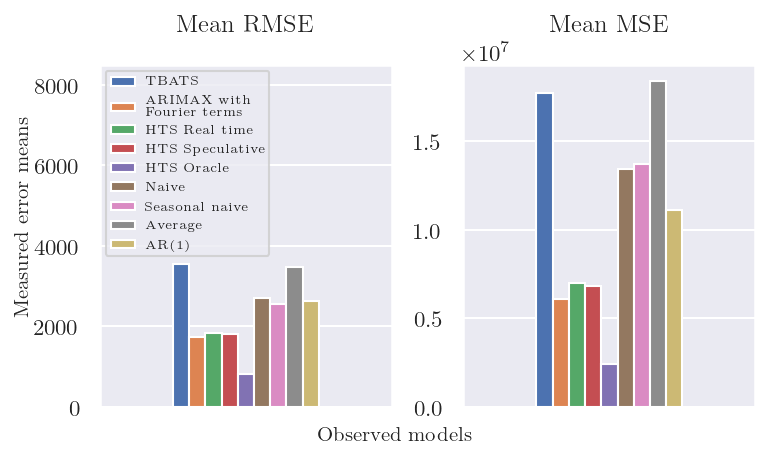

In [78]:
fig, ax = plt.subplots(1, 2, tight_layout=True, dpi=150)
fig.set_size_inches(w=5.10686, h=3)

#fig.set_size_inches(8, 4)



results[['mean_tbats_rmse', 'mean_arimax_rmse','mean_total_rt_rmse',
         'mean_total_speculative_rmse', 'mean_oracle_rmse',
         'mean_naive_rmse', 'mean_seasonal_naive_rmse',
         'mean_average_rmse', 'mean_ar1_rmse']].plot(kind='bar', ax=ax[0])#, color=sns.color_palette("muted", n_colors=8))

ax[0].set_title("Mean RMSE", pad=16)

ax[0].get_xaxis().set_ticks([])
#ax[0].set_xlabel("Models")


ax[0].set_ylim(ymax=8500)


results[['mean_tbats_mse', 'mean_arimax_mse', 'mean_total_rt_mse',
         'mean_total_speculative_mse', 'mean_oracle_mse',
         'mean_naive_mse', 'mean_seasonal_naive_mse',
         'mean_average_mse', 'mean_ar1_mse' 
        ]].plot(kind='bar', ax=ax[1])

ax[1].set_title("Mean MSE", pad=16)
ax[1].get_legend().remove()
            
ax[0].legend(["TBATS", "ARIMAX with\nFourier terms", 'HTS Real time',
              'HTS Speculative',  'HTS Oracle',
              "Naive", "Seasonal naive",
              "Average", 'AR(1)'], fontsize="xx-small", loc='upper left')
            
ax[1].get_xaxis().set_ticks([])
#ax[1].set_ylim(ymax=40000000)
#ax[1].set_xlabel("Models")

fig.text(0.5, 0.004, 'Observed models', ha='center')
fig.text(0.004, 0.5, 'Measured error means', va='center', rotation='vertical')


fig.savefig('../../plots/text-plots/8-15min-hts-combined-rmse.pgf')

In [73]:
1 - (results['oracle_rmse'] / results['total_rt_rmse'])

0    0.555857
dtype: float64

In [74]:
1 - (results['oracle_mse'] / results['total_rt_mse'])

0    0.653766
dtype: float64

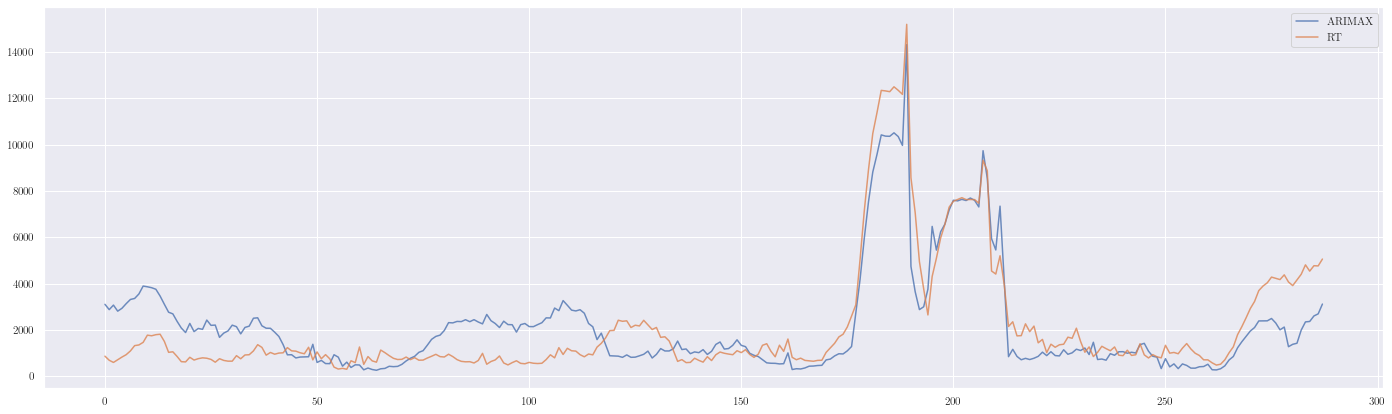

In [602]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 7)

#naive_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
#average_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
#seasonal_naive_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
#ar1_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
arimax_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
#tbats_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
total_rt_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
#total_speculative_rmse[:day_observations*3].plot(ax=ax, alpha=0.8)
ax.legend([ "ARIMAX", "RT", ]) #"Naive", "Average", "Seasonal Naive", "AR(1)", "TBATS","Speculative"